In [137]:
import midynet
from midynet.utility import display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pathlib
import numpy as np
import fractions


display.setup_dir("./")

paths_to_figures = [".", "../../../../papers/p-midynet/paper1-mutual_info/figures"]
paths_to_figures = list(map(pathlib.Path, paths_to_figures))

path_to_data = pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/local-data/midynet-data/figure2/")
# path_to_data = pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/duality/figure2/")


## Loading data from experiment

In [141]:


exp = {}
bit_ratio = np.log(2)
hg, hg_past, hx, hx_past, mi, mi_past = {}, {}, {}, {}, {}, {}

all_dynamics = ["glauber"]
for dynamics in all_dynamics:
    name = f"exact-{dynamics}"
    if (path_to_data / name / "config.pickle").exists():
        exp[dynamics] = midynet.Experiment.load_from_file(path_to_data / name / "config.pickle")
        data = exp[dynamics].metrics["recon_information"].data[exp[dynamics].name]
        hg[dynamics] = midynet.Statistics(data, name="prior")
        hg_past[dynamics] = midynet.Statistics(data, name="posterior_past")
        hx[dynamics] = midynet.Statistics(data, name="evidence")
        hx_past[dynamics] = midynet.Statistics(data, name="evidence_past")
        mi[dynamics] = midynet.Statistics(data, name="mutualinfo")
        mi_past[dynamics] = midynet.Statistics(data, name="mutualinfo") - midynet.Statistics(data, name="mutualinfo_past")

xlabel = r"Number of time steps"
titles = {"glauber": r"Glauber", "sis": r"SIS", "cowan": r"Cowan"}
coupling_labels = {"glauber": r"J\langle k \rangle", "sis": r"\lambda \langle k \rangle", "cowan": r"\nu\langle k \rangle"}
coupling_names = {"glauber": "coupling", "sis": r"infection_prob", "cowan": r"nu"}

In [143]:

print(exp["glauber"].config.data_model.past_length)
print(mi["glauber"][:, 0, 0]["mid"], mi_past["glauber"][:, 0, 0]["mid"])
print(mi["glauber"][:, 0, 1]["mid"], mi_past["glauber"][:, 0, 1]["mid"])
print(mi["glauber"][:, 0, 2]["mid"], mi_past["glauber"][:, 0, 2]["mid"])
print(mi["glauber"][:, 0, 3]["mid"], mi_past["glauber"][:, 0, 3]["mid"])


[-5, -1, 0, 0.5]
[1.79479233 1.94571482 2.56088085 3.22305498 3.83526129 4.72671171
 5.40264826 6.10239976 6.72253363 7.26918595] [0.83627074 0.75007083 0.68167011 0.58123597 0.54810899 0.42179031
 0.3498701  0.32174785 0.15437328 0.09531134]
[1.79479233 1.94571482 2.56088085 3.22305498 3.83526129 4.72671171
 5.40264826 6.10239976 6.72253363 7.26918595] [0.16779385 0.14463572 0.13357264 0.12146314 0.10427189 0.07888084
 0.05661209 0.06653361 0.02544255 0.02497344]
[1.79479233 1.94571482 2.56088085 3.22305498 3.83526129 4.72671171
 5.40264826 6.10239976 6.72253363 7.26918595] [1.79479233 1.94571482 2.56088085 3.22305498 3.83526129 4.72671171
 5.40264826 6.10239976 6.72253363 7.26918595]
[1.79479233 1.94571482 2.56088085 3.22305498 3.83526129 4.72671171
 5.40264826 6.10239976 6.72253363 7.26918595] [0.83627074 0.9253694  1.08199594 1.44616726 1.73018803 1.87930946
 1.97894486 2.13258547 1.8550475  1.78142645]


## Figure 2 revisited

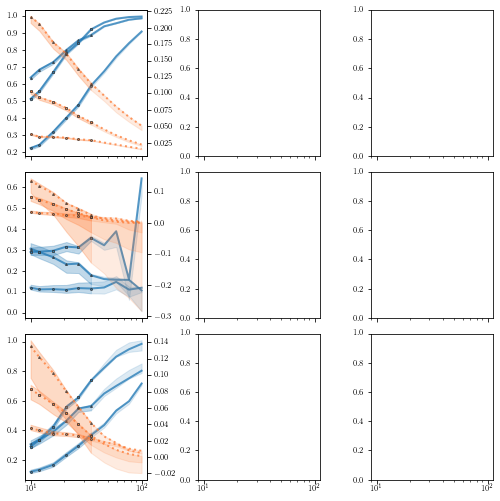

In [153]:
fig, ax = plt.subplots(3, 3, figsize=(7, 7), sharex=True, sharey=False)

ax = {dynamics: ax[:,i] for i, dynamics in enumerate(all_dynamics)}
axx = {dynamics: [_ax.twinx() for _ax in ax[dynamics]] for i, dynamics in enumerate(all_dynamics)}


recon_color = display.med_colors["blue"]
pred_color = display.dark_colors["orange"]


spacing = 7
min_index = 5
recon_yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
pred_yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

markers = ["o", "s", "^", "*"]
for dynamics_id, dynamics in enumerate(all_dynamics):
    if dynamics not in exp:
        continue
    x = np.array(exp[dynamics].config.data_model.length)
    m_indices = list(range(min_index)) + list(range(min_index, len(x), spacing))
    coupling = exp[dynamics].config.data_model.get_value(coupling_names[dynamics])
    tau = exp[dynamics].config.data_model.get_value("past_length")
    if dynamics == "sis":
        coupling = [c / exp[dynamics].config.data_model.recovery_prob for c in coupling]
    alpha = np.linspace(0, 1, len(coupling) + 2)[2:] ** 1.5
    recon = mi_past[dynamics] / hg_past[dynamics]
    pred = mi_past[dynamics] / (hx[dynamics] - hx_past[dynamics])
    tau = [0, -5, 0.5]
    tau_indices = [2, 0, 3]
    for i, (t_index, t) in enumerate(zip(tau_indices, tau)):
        for c_index, (c, a) in reversed(list(enumerate(zip(coupling, alpha)))):
            y = recon if len(coupling) == 1 else recon[:, c_index, t_index]
            display.plot_statistics(
                x, y,
                ax=ax[dynamics][i], 
                color=recon_color,
                alpha=0.75,
                linestyle="-",
                marker="None",
                linewidth=2,
                markersize=2,
                markeredgecolor=display.dark_colors["grey"],
                bar=False,
            )
            y = recon[m_indices] if len(coupling) == 1 else recon[m_indices, c_index, t_index]
            display.plot_statistics(
                x[m_indices], y,
                ax=ax[dynamics][i], 
                color=recon_color,
                alpha=0.75,
                linestyle="None",
                marker=markers[c_index],
                markersize=2,
                markeredgecolor=display.dark_colors["grey"],
                bar=False,
            )


            y = pred if len(coupling) == 1 else pred[:, c_index, t_index]
            display.plot_statistics(
                x, y,
                ax=axx[dynamics][i], 
                color=pred_color,
                alpha=0.75,
                linestyle="dotted",
                linewidth=2,
                marker="None",
                markeredgecolor=display.dark_colors["grey"],
                markersize=2,
                bar=False,
            )
            y = pred[m_indices] if len(coupling) == 1 else pred[m_indices, c_index, t_index]
            display.plot_statistics(
                x[m_indices], y,
                ax=axx[dynamics][i], 
                color=pred_color,
                alpha=0.75,
                linestyle="None",
                marker=markers[c_index],
                markersize=2,
                markeredgecolor=display.dark_colors["grey"],
                bar=False,
            )
            ax[dynamics][i].set_xscale("log")
#             ax[dynamics][i].set_ylim([0, ax[dynamics][i].get_ylim()[-1]])
            axx[dynamics][i].set_xscale("log")
#             axx[dynamics][i].set_ylim([0, axx[dynamics][i].get_ylim()[-1]])
    
#     if dynamics_id == 0:
#         ax[dynamics].set_ylabel(r"Reconstructability", fontsize=display.fontsizes["large"])
#         ax[dynamics].set_yticks(recon_yticks)
# #         ax[dynamics].set_yticklabels([fractions.Fraction(x).limit_denominator() for x in recon_yticks])
        
#     if dynamics_id == len(all_dynamics)-1:
#         axx[dynamics].set_ylabel(r"Predictability", fontsize=display.fontsizes["large"], rotation=-90, rotation_mode="anchor", va="bottom")
#         axx[dynamics].set_yticks(pred_yticks)
# #         axx[dynamics].set_yticklabels([fractions.Fraction(x).limit_denominator() for x in pred_yticks])
#     else:
#         axx[dynamics].axes.xaxis.set_ticklabels([])
#         axx[dynamics].axes.yaxis.set_ticklabels([])
#     ax[dynamics].set_xlabel(xlabel, fontsize=display.fontsizes["large"])
#     ax[dynamics].tick_params(axis='both', labelsize=display.fontsizes["medium"])
#     ax[dynamics].set_xlim([1, 1000])
#     ax[dynamics].set_ylim([0., 1.])
#     ax[dynamics].set_xscale("log")
#     ax[dynamics].set_title(titles[dynamics], fontsize=display.fontsizes["large"])
    
#     axx[dynamics].set_xlabel(xlabel, fontsize=display.fontsizes["large"])
#     axx[dynamics].tick_params(axis='both', labelsize=display.fontsizes["medium"])
#     axx[dynamics].set_xlim([1, 1e4])
#     axx[dynamics].set_xscale("log")
#     axx[dynamics].set_ylim([0, 0.5])
    
#     handles = [
#         Line2D(
#             [0], [0], 
#             marker=markers[i], 
#             linestyle="-", 
#             color=display.dark_colors["grey"], 
#             label=rf"${couplingLabels[dynamics]} = {fractions.Fraction(c)}$", 
#             alpha=0.5,
#             markersize=2,
#             linewidth=1,
#         )
#         for i, c in reversed(list(enumerate(coupling)))
#     ]
#     ax[dynamics].legend(handles=handles, loc="center right", fontsize=display.fontsizes["small"], ncol=1, frameon=True)
#     ax[dynamics].tick_params(axis='y', colors=recon_color, length=6, width=2)
    
#     axx[dynamics].spines['left'].set_color(recon_color)
#     axx[dynamics].spines['left'].set_linewidth(2)
#     axx[dynamics].spines['right'].set_color(pred_color)
#     axx[dynamics].spines['right'].set_linewidth(2)
#     axx[dynamics].tick_params(axis='y', colors=pred_color, length=6, width=2)

# for dynamics in all_dynamics:
#     display.Label.plot(ax[dynamics], loc="top left", fontsize=display.fontsizes["medium"], box=True)
# display.Label.clear()

# handles = [Line2D([0], [0], marker="None", linestyle="-", color=recon_color, label=r"Reconstructability", alpha=1, lw=2, ms=2)]
# handles += [Line2D([0], [0], marker="None", linestyle="dotted", color=pred_color, label=r"Predictability", alpha=1, lw=2, ms=2)]
# lg = fig.legend(handles=handles, loc="center", fontsize=display.fontsizes["large"], ncol=2, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
# plt.subplots_adjust(wspace=0.15)

# for p in paths_to_figures:
#     fig.savefig(p / "svg/p1-figure2.svg", bbox_extra_artists=(lg,), bbox_inches='tight')
#     fig.savefig(p / "pdf/p1-figure2.pdf", bbox_extra_artists=(lg,), bbox_inches='tight')
#     fig.savefig(p / "png/p1-figure2.png", bbox_extra_artists=(lg,), bbox_inches='tight')

In [99]:
exp["glauber"].config.data_model.past_length

[-5, -1, 0, 0.5]

In [151]:
hg_past

{'glauber': Statistics(mid=[[[7.01875834e+00 6.35028144e+00 7.97727992e+00 7.01875834e+00]
   [5.45387267e+00 4.14676378e+00 7.97727992e+00 5.45387267e+00]
   [4.13725486e+00 3.04588618e+00 7.97727992e+00 4.13725486e+00]]
 
  [[6.78163593e+00 6.17620082e+00 7.97727992e+00 6.95693450e+00]
   [4.94305718e+00 3.77959815e+00 7.97727992e+00 5.26149349e+00]
   [3.52009308e+00 2.68763063e+00 7.97727992e+00 3.76899358e+00]]
 
  [[6.09806919e+00 5.54997172e+00 7.97727992e+00 6.49839502e+00]
   [3.70743990e+00 2.83676103e+00 7.97727992e+00 4.53489812e+00]
   [2.91116832e+00 2.25961875e+00 7.97727992e+00 3.51009037e+00]]
 
  [[5.33546091e+00 4.87568808e+00 7.97727992e+00 6.20039220e+00]
   [2.53125679e+00 1.89770962e+00 7.97727992e+00 3.92355137e+00]
   [2.04895079e+00 1.66557985e+00 7.97727992e+00 2.94232228e+00]]
 
  [[4.69012763e+00 4.24629053e+00 7.97727992e+00 5.87220667e+00]
   [1.80098272e+00 1.33751327e+00 7.97727992e+00 3.28645290e+00]
   [1.46502161e+00 1.19137395e+00 7.97727992e+00 2.4